In [ ]:
pip install backtrader yfinance pandas matplotlib vectorbt ccxt numpy scipy polars arch pandas-datareader requests seaborn

2025-02-26 16:49:50,099 - INFO - Iniciando análise completa da arbitragem (GLD vs PAXGOLD)...
2025-02-26 16:49:50,100 - INFO - Usando dados em cache: gold_data\GLD_TIME_SERIES_DAILY.csv (modificado em 2025-02-26 12:05:02)
2025-02-26 16:49:50,109 - INFO - Usando dados em cache: gold_data\PAXGOLD_CCXT_1d.csv (modificado em 2025-02-26 12:38:33)
2025-02-26 16:49:50,118 - INFO - Dados preparados com sucesso.
2025-02-26 16:49:50,165 - INFO - Usando dados em cache: gold_data\FRED_DTB3.csv (modificado em 2025-02-26 12:45:41)
C:\Users\samue\AppData\Local\Temp\ipykernel_11532\3501839069.py:293: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)'


=== ARBITRAGEM: GLD vs PAXGOLD ===
Período: 11/04/2023 a 11/07/2024 (315 dias)

PARÂMETROS:
  Z-Score Entrada: 1.5
  Z-Score Saída: 0.0
  Uso de filtro EMA: False

RESULTADOS:
  Retorno Estratégia: 22.50% (17.63% anual)
  GLD Buy & Hold:   19.85% (15.58% anual)
  PAXGOLD Buy & Hold: 18.31% (14.40% anual)

MÉTRICAS DE RISCO:
  Volatilidade Anualizada: 4.95%
  Índice Sharpe:           3.56
  Drawdown Máximo:         -2.91%

OPERAÇÕES:
  Número de Trades: 37
  Taxa de Acerto:   100.00%
  Trades por Ano:   29.60


2025-02-26 16:49:51,219 - INFO - Gráfico percentual salvo em: gold_data\gold_paxg_arbitrage_report.png


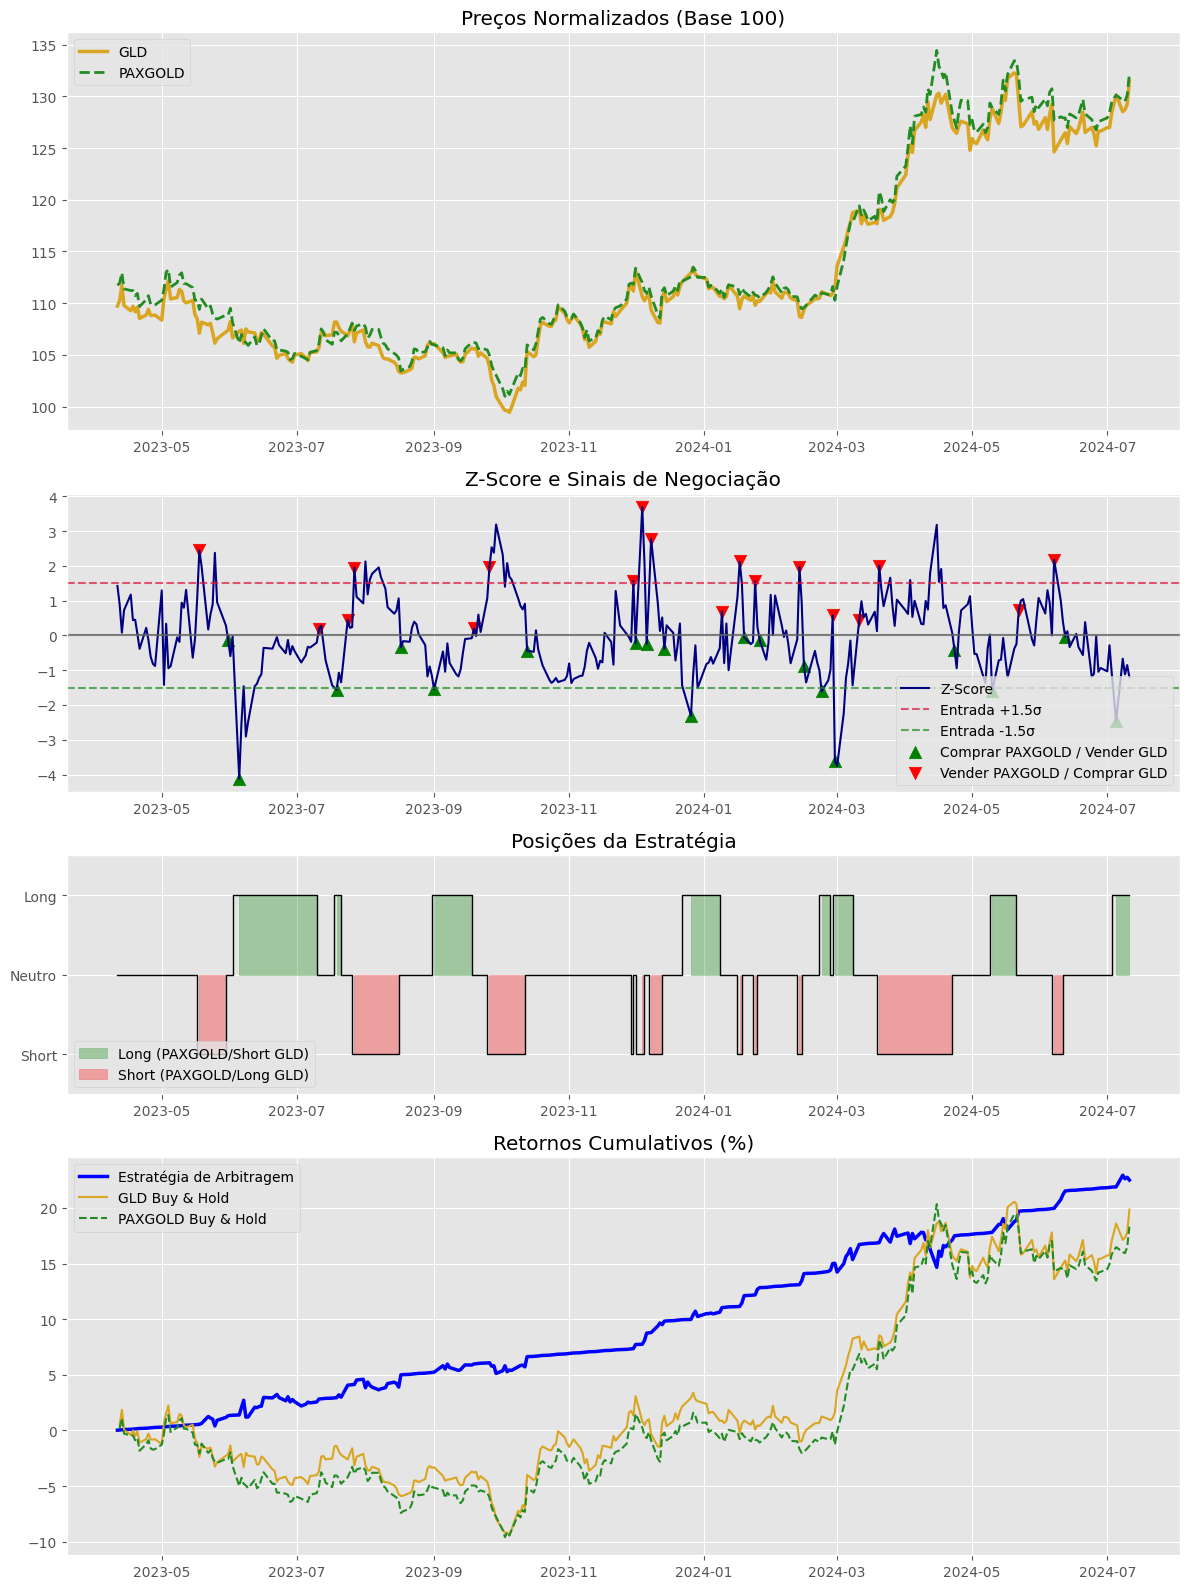

2025-02-26 16:49:51,857 - INFO - Gráfico de capital salvo em: gold_data\capital_curves.png


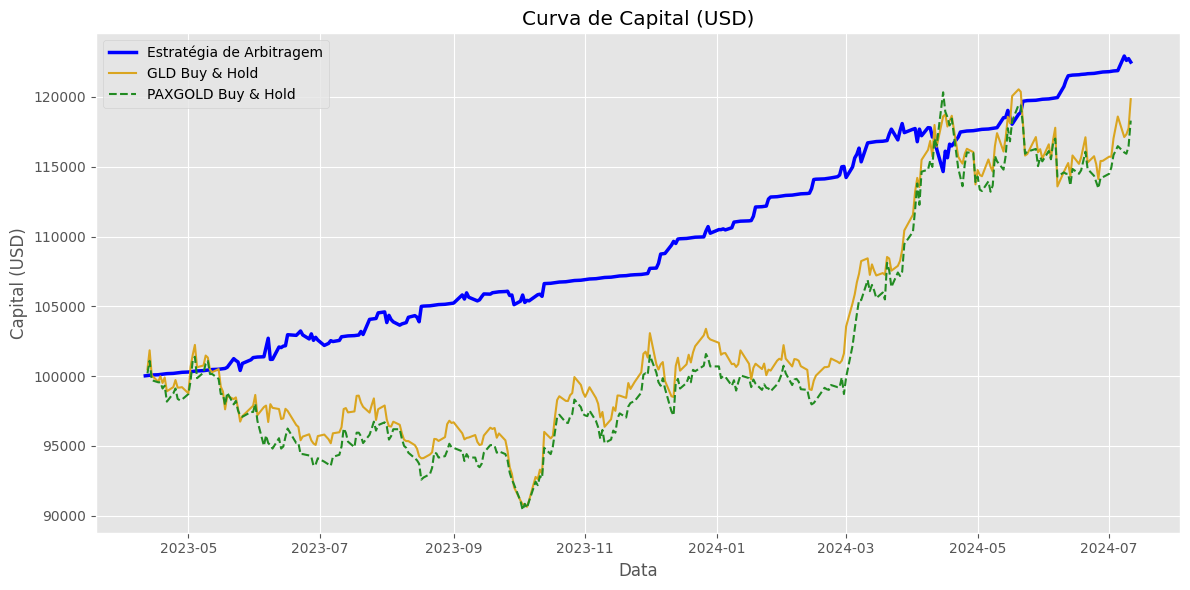

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Carregamento dos dados
# -----------------------------
base_folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários dos ETFs, do XAUUSD e da taxa de juros (FRED)
gld   = pd.read_csv(os.path.join(base_folder, "GLD_daily.csv"), index_col=0, parse_dates=True)
iau   = pd.read_csv(os.path.join(base_folder, "IAU_daily.csv"), index_col=0, parse_dates=True)
paxg  = pd.read_csv(os.path.join(base_folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(base_folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)
fred  = pd.read_csv(os.path.join(base_folder, "fred_interest_rates.csv"), index_col=0, parse_dates=True)

# -----------------------------
# 2. Filtragem do período (2022 a 2025)
# -----------------------------
start = pd.to_datetime("2022-01-01")
end   = pd.to_datetime("2025-01-01")

gld   = gld[(gld.index >= start) & (gld.index < end)]
iau   = iau[(iau.index >= start) & (iau.index < end)]
paxg  = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]
fred  = fred[(fred.index >= start) & (fred.index < end)]

# -----------------------------
# 3. Ajuste de escalas (preço por onça)
# -----------------------------
# GLD: cada cota representa 1/10 de onça => multiplicar por 10
gld["price_oz"] = gld["close"] * 10
# IAU: cada cota representa 1/100 de onça => multiplicar por 100
iau["price_oz"] = iau["close"] * 100
# PAXG: já representa 1 onça
paxg["price_oz"] = paxg["close"]
# XAUUSD: já assume que "close" é o preço do ouro físico por onça

# -----------------------------
# 4. Alinhamento dos dados
# -----------------------------
# Para os ETFs e XAUUSD, usamos a interseção dos índices
common_dates = gld.index.intersection(iau.index).intersection(paxg.index).intersection(xauusd.index)
gld    = gld.loc[common_dates]
iau    = iau.loc[common_dates]
paxg   = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Para o FRED, criamos um DateRange de dias úteis e reindexamos com ffill
business_dates = pd.date_range(start, end, freq='B')
fred = fred.sort_index().reindex(business_dates, method='ffill')

# Utilizaremos a coluna 'close' do FRED para representar a taxa (pois open, high, low, close são iguais)
if "close" not in fred.columns:
    raise Exception("O arquivo FRED não possui a coluna 'close'.")
fred["risk_free"] = (1 + fred["close"] / 100) ** (1/252) - 1

# -----------------------------
# 5. Criação do DataFrame unificado
# -----------------------------
df = pd.DataFrame(index=common_dates)
df["GLD"]    = gld["price_oz"]
df["IAU"]    = iau["price_oz"]
df["PAXG"]   = paxg["price_oz"]
df["XAUUSD"] = xauusd["close"]

# Preço médio dos ETFs (direitos ao ouro)
df["avg_etf"] = df[["GLD", "IAU", "PAXG"]].mean(axis=1)

# Junta a taxa risk_free, reindexando para as datas comuns
fred_risk = fred["risk_free"].reindex(df.index, method='ffill')
df = df.join(fred_risk)

# -----------------------------
# 6. Geração do sinal de arbitragem
# -----------------------------
# Estratégia: se o preço médio dos ETFs estiver abaixo do preço do ouro físico (XAUUSD),
# então os ETFs estão "baratos". Sinal = 1 (comprar ETFs, vender XAUUSD); caso contrário, 0.
df["signal"] = np.where(df["avg_etf"] < df["XAUUSD"], 1, 0)

# -----------------------------
# 7. Cálculo dos retornos diários
# -----------------------------
# Retornos diários open-to-close para os ativos
gld["ret"]    = (gld["close"] * 10 / (gld["open"] * 10)) - 1
iau["ret"]    = (iau["close"] * 100 / (iau["open"] * 100)) - 1
paxg["ret"]   = (paxg["close"] / paxg["open"]) - 1
xauusd["ret"] = (xauusd["close"] / xauusd["open"]) - 1

# Retorno médio dos ETFs (buy & hold dos direitos ao ouro)
df["etf_ret"] = (gld["ret"] + iau["ret"] + paxg["ret"]) / 3.0
# Retorno do XAUUSD (buy & hold do ouro físico)
df["xauusd_ret"] = xauusd["ret"]

# -----------------------------
# 8. Cálculo do retorno da estratégia
# -----------------------------
# Se não estivermos posicionado (sinal do dia anterior = 0), alocamos a taxa risk-free.
# Se estivermos posicionado (sinal = 1), o retorno é dado pela diferença (etf_ret - xauusd_ret).
df["strategy_ret"] = np.where(
    df["signal"].shift(1) == 0,
    df["risk_free"],
    df["signal"].shift(1) * (df["etf_ret"] - df["xauusd_ret"])
)
df["cum_ret"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

# -----------------------------
# 9. Cálculo dos retornos buy & hold dos ativos para comparação
# -----------------------------
cum_gld = (1 + gld["ret"]).cumprod()
cum_iau = (1 + iau["ret"]).cumprod()
cum_paxg = (1 + paxg["ret"]).cumprod()
# Média dos ETFs
cum_etf = (cum_gld + cum_iau + cum_paxg) / 3.0
cum_xauusd = (1 + xauusd["ret"]).cumprod()
cum_riskfree = (1 + fred_risk.reindex(df.index, method='ffill')).cumprod()

# -----------------------------
# 10. Visualização dos resultados
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df["cum_ret"], label="Estratégia", color="green")
plt.plot(df.index, cum_etf, label="Buy & Hold (ETFs)", linestyle="--")
plt.plot(df.index, cum_xauusd, label="Buy & Hold (XAUUSD)", linestyle=":")
plt.plot(df.index, cum_riskfree, label="Taxa Risk-Free", linestyle="-.", color="gray")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.title("Comparação: Estratégia vs. Buy & Hold dos Ativos")
plt.legend()
plt.grid(True)
plt.show()

# Exibe os retornos finais
print("Retorno acumulado - Estratégia: {:.2f}%".format((df["cum_ret"].iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold (ETFs): {:.2f}%".format((cum_etf.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold (XAUUSD): {:.2f}%".format((cum_xauusd.iloc[-1]-1)*100))
print("Retorno acumulado - Taxa Risk-Free: {:.2f}%".format((cum_riskfree.iloc[-1]-1)*100))


2025-02-27 10:48:12,861 - INFO - Iniciando análise completa da arbitragem (GLD vs PAXGOLD)...
2025-02-27 10:48:12,862 - INFO - Usando dados em cache: gold_data\GLD_TIME_SERIES_DAILY.csv (modificado em 2025-02-26 12:05:02)
C:\Users\samue\AppData\Local\Temp\ipykernel_27448\4176946104.py:118: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  since = exchange.parse8601((datetime.utcnow() - timedelta(days=365 * 2)).isoformat())
2025-02-27 10:48:16,271 - INFO - Buscando dados de PAXG/USDT na Binance via CCXT...
2025-02-27 10:48:16,561 - INFO - Dados salvos em cache: gold_data\PAXGOLD_CCXT_1d.csv
2025-02-27 10:48:16,595 - INFO - Dados preparados com sucesso.
2025-02-27 10:48:16,640 - INFO - Estratégia executada com sucesso.



=== ARBITRAGEM: GLD vs PAXGOLD ===
Período: 12/04/2023 a 12/07/2024 (315 dias)

PARÂMETROS:
  Z-Score Entrada: 1.5
  Z-Score Saída: 0.0
  Uso de filtro EMA: False

RESULTADOS:
  Retorno Estratégia: 18.36% (14.44% anual)
  GLD Buy & Hold:   19.19% (15.08% anual)
  PAXGOLD Buy & Hold: 18.02% (14.18% anual)

MÉTRICAS DE RISCO:
  Volatilidade Anualizada: 4.98%
  Índice Sharpe:           2.90
  Drawdown Máximo:         nan%

OPERAÇÕES:
  Número de Trades: 37
  Taxa de Acerto:   48.65%
  Trades por Ano:   29.60


2025-02-27 10:48:17,598 - INFO - Gráfico salvo em: gold_data\gold_paxg_arbitrage_report.png


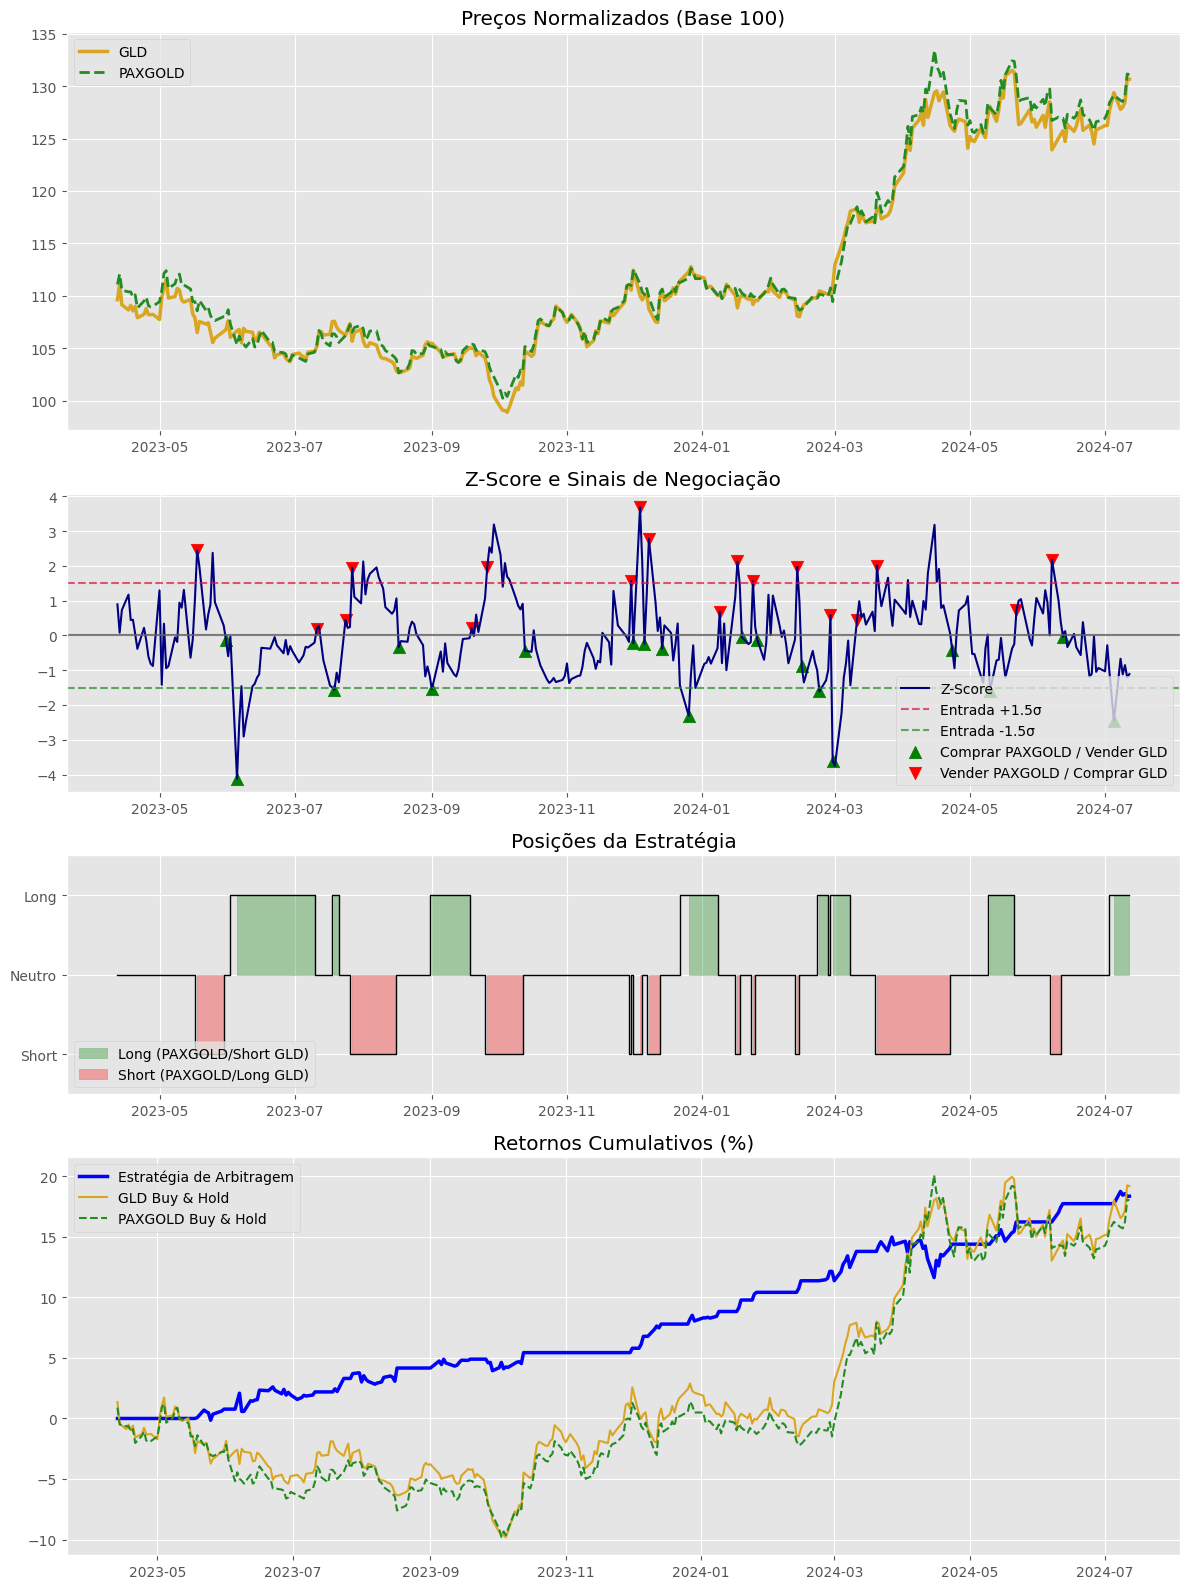

In [1]:
import requests
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import logging

# Configurações iniciais
API_KEY = 'HO1ZP4R8DC6P1F6W'
DATA_DIR = 'gold_data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Parâmetros padrão da estratégia
Z_ENTRY = 1.5    # Limiar de Z-Score para entrada
Z_EXIT = 0.0     # Limiar de Z-Score para saída
USE_EMA = False  # Filtro EMA desativado por padrão
Z_WINDOW = 30    # Janela para cálculo do Z-Score

# Configuração simples de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def load_cache(cache_file, max_age_hours):
    """Tenta carregar dados em cache se o arquivo existir e não estiver expirado."""
    if os.path.exists(cache_file):
        file_time = datetime.fromtimestamp(os.path.getmtime(cache_file))
        if datetime.now() - file_time < timedelta(hours=max_age_hours):
            logging.info(f"Usando dados em cache: {cache_file} (modificado em {file_time.strftime('%Y-%m-%d %H:%M:%S')})")
            return pd.read_csv(cache_file, index_col=0, parse_dates=True)
    return None


def save_cache(df, cache_file):
    """Salva o DataFrame em arquivo CSV para cache."""
    df.to_csv(cache_file)
    logging.info(f"Dados salvos em cache: {cache_file}")


class GoldArbitrageStrategy:
    def __init__(self, start_date=None, z_entry=Z_ENTRY, z_exit=Z_EXIT, use_ema=USE_EMA, z_window=Z_WINDOW):
        self.start_date = start_date or (datetime.now() - timedelta(days=365 * 2))
        self.z_entry = z_entry
        self.z_exit = z_exit
        self.use_ema = use_ema
        self.z_window = z_window

    def fetch_gld_data(self, use_cached=True, cache_days=7):
        """
        Busca dados diários do GLD via Alpha Vantage.
        Usa cache (cache_days) para evitar requisições repetidas.
        """
        cache_file = os.path.join(DATA_DIR, "GLD_TIME_SERIES_DAILY.csv")
        if use_cached:
            df_cache = load_cache(cache_file, max_age_hours=cache_days * 24)
            if df_cache is not None:
                return df_cache

        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GLD&outputsize=full&apikey={API_KEY}'
        logging.info("Buscando dados do GLD via Alpha Vantage...")
        try:
            response = requests.get(url)
            data = response.json()
            # Checa possíveis mensagens de erro ou informação
            for key in ['Error Message', 'Information']:
                if key in data:
                    logging.error(f"{key}: {data[key]}")
                    return None

            # Encontrar a chave com os dados de série temporal
            time_series_key = next((k for k in data.keys() if 'Time Series' in k), None)
            if not time_series_key or not data.get(time_series_key):
                logging.error("Dados do GLD não encontrados na resposta da API.")
                return None

            df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
            # Renomear colunas para nomes mais simples
            col_map = {
                '1. open': 'open',
                '2. high': 'high',
                '3. low': 'low',
                '4. close': 'close',
                '5. volume': 'volume'
            }
            df.rename(columns=col_map, inplace=True)
            # Converter colunas para numérico e index para datetime
            for col in df.columns:
                df[col] = pd.to_numeric(df[col])
            df.index = pd.to_datetime(df.index)
            df.sort_index(inplace=True)

            save_cache(df, cache_file)
            return df

        except Exception as e:
            logging.error(f"Erro ao buscar dados do GLD: {str(e)}")
            return None

    def fetch_paxgold_data_ccxt(self, use_cached=True, cache_hours=12):
        """
        Busca dados diários do PAXGOLD via CCXT.
        Usa a Binance (ou outra exchange disponível) e o par PAXG/USDT.
        """
        cache_file = os.path.join(DATA_DIR, "PAXGOLD_CCXT_1d.csv")
        if use_cached:
            df_cache = load_cache(cache_file, max_age_hours=cache_hours)
            if df_cache is not None:
                return df_cache

        try:
            exchange = ccxt.binance({'enableRateLimit': True})
            exchange.load_markets()
            symbol = 'PAXG/USDT'
            timeframe = '1d'
            # Define o período: últimos 2 anos (em milissegundos)
            since = exchange.parse8601((datetime.utcnow() - timedelta(days=365 * 2)).isoformat())
            logging.info(f"Buscando dados de {symbol} na Binance via CCXT...")
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=500)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('datetime', inplace=True)
            df.drop('timestamp', axis=1, inplace=True)
            df.sort_index(inplace=True)

            save_cache(df, cache_file)
            return df

        except Exception as e:
            logging.error(f"Erro ao buscar dados do PAXGOLD via CCXT: {str(e)}")
            return None

    def prepare_data(self):
        """
        Prepara os dados para análise de arbitragem:
         - Busca os dados do GLD (Alpha Vantage) e do PAXGOLD (CCXT).
         - Filtra por datas comuns e a partir da data de início.
         - Calcula indicadores técnicos (EMAs, normalização, spread e z‑score).
        """
        self.gld = self.fetch_gld_data()
        if self.gld is None:
            logging.error("Não foi possível obter dados do GLD.")
            return False

        self.paxg = self.fetch_paxgold_data_ccxt()
        if self.paxg is None:
            logging.error("Não foi possível obter dados do PAXGOLD via CCXT.")
            return False

        # Encontrar datas comuns entre GLD e PAXGOLD
        common_dates = self.gld.index.intersection(self.paxg.index)
        if len(common_dates) < 50:
            logging.error("Dados insuficientes após alinhar datas comuns.")
            return False

        self.gld = self.gld.loc[common_dates]
        self.paxg = self.paxg.loc[common_dates]

        # Filtrar a partir da data de início definida
        self.gld = self.gld[self.gld.index >= self.start_date]
        self.paxg = self.paxg[self.paxg.index >= self.start_date]

        # Calcula EMAs se necessário (mesmo que não seja usado, pode servir para futuros filtros)
        for df in [self.gld, self.paxg]:
            df['ema_long'] = df['close'].ewm(span=20, adjust=False).mean()
            df['ema_short'] = df['close'].ewm(span=9, adjust=False).mean()

        # Cria DataFrame unificado para análise de arbitragem
        self.df = pd.DataFrame(index=self.gld.index)
        self.df['gld_price'] = self.gld['close']
        self.df['paxg_price'] = self.paxg['close']

        # Normalização dos preços (base 100)
        first_gld = self.df['gld_price'].iloc[0]
        first_paxg = self.df['paxg_price'].iloc[0]
        self.df['gld_norm'] = self.df['gld_price'] / first_gld * 100
        self.df['paxg_norm'] = self.df['paxg_price'] / first_paxg * 100

        # Cálculo do spread percentual e do z-score
        self.df['spread'] = (self.df['paxg_norm'] / self.df['gld_norm'] - 1) * 100
        self.df['spread_mean'] = self.df['spread'].rolling(window=self.z_window).mean()
        self.df['spread_std'] = self.df['spread'].rolling(window=self.z_window).std()
        self.df['z_score'] = (self.df['spread'] - self.df['spread_mean']) / self.df['spread_std']

        # Indicadores adicionais para filtros (se desejado usar EMAs)
        self.df['gld_ema_long'] = self.gld['ema_long']
        self.df['gld_ema_short'] = self.gld['ema_short']
        self.df['paxg_ema_long'] = self.paxg['ema_long']
        self.df['paxg_ema_short'] = self.paxg['ema_short']
        self.df['gld_trend'] = np.where(self.df['gld_ema_short'] > self.df['gld_ema_long'], 1, -1)
        self.df['paxg_trend'] = np.where(self.df['paxg_ema_short'] > self.df['paxg_ema_long'], 1, -1)

        # Remover linhas com NaN resultantes dos cálculos
        self.df.dropna(inplace=True)
        logging.info("Dados preparados com sucesso.")
        return True

    def run_strategy(self):
        """
        Executa a estratégia de arbitragem:
         - Percorre o DataFrame e, com base no z-score (e filtro EMA se ativado),
           gera sinais e posições:
              * Sem posição: se z_score <= -z_entry (comprar PAXGOLD/vender GLD)
                ou se z_score >= z_entry (vender PAXGOLD/comprar GLD).
              * Em posição: fecha a operação se o z_score voltar próximo do z_exit.
         - Calcula retornos diários e cumulativos.
        """
        if not hasattr(self, 'df') or self.df is None:
            logging.error("Dados não preparados. Execute prepare_data() primeiro.")
            return False

        self.df['signal'] = 0
        self.df['position'] = 0

        for i in range(1, len(self.df)):
            curr_date = self.df.index[i]
            prev_date = self.df.index[i - 1]
            z_score = self.df.loc[curr_date, 'z_score']
            prev_position = self.df.loc[prev_date, 'position']

            # Se usar filtro EMA, exige que o GLD esteja em tendência de alta
            ema_filter = True
            if self.use_ema:
                ema_filter = (self.df.loc[curr_date, 'gld_trend'] == 1)

            if prev_position == 0:
                if z_score <= -self.z_entry and ema_filter:
                    self.df.loc[curr_date, 'signal'] = 1   # Sinal de entrada: comprar PAXGOLD, vender GLD
                    self.df.loc[curr_date, 'position'] = 1
                elif z_score >= self.z_entry and ema_filter:
                    self.df.loc[curr_date, 'signal'] = -1  # Sinal de entrada: vender PAXGOLD, comprar GLD
                    self.df.loc[curr_date, 'position'] = -1
                else:
                    self.df.loc[curr_date, 'position'] = 0
            elif prev_position == 1:
                if z_score >= self.z_exit:
                    self.df.loc[curr_date, 'signal'] = -1  # Sair da posição
                    self.df.loc[curr_date, 'position'] = 0
                else:
                    self.df.loc[curr_date, 'position'] = 1
            elif prev_position == -1:
                if z_score <= -self.z_exit:
                    self.df.loc[curr_date, 'signal'] = 1   # Sair da posição
                    self.df.loc[curr_date, 'position'] = 0
                else:
                    self.df.loc[curr_date, 'position'] = -1

        # Cálculo dos retornos diários e da estratégia
        self.df['paxg_return'] = self.df['paxg_price'].pct_change()
        self.df['gld_return'] = self.df['gld_price'].pct_change()
        self.df['arb_return'] = self.df['position'].shift(1) * (self.df['paxg_return'] - self.df['gld_return'])
        self.df['cum_arb'] = (1 + self.df['arb_return']).cumprod() - 1
        self.df['cum_gld'] = (1 + self.df['gld_return']).cumprod() - 1
        self.df['cum_paxg'] = (1 + self.df['paxg_return']).cumprod() - 1

        logging.info("Estratégia executada com sucesso.")
        return True

    def calculate_metrics(self):
        """Calcula métricas de desempenho da estratégia."""
        n_days = len(self.df)
        n_trades = self.df['signal'].abs().sum()
        win_trades = self.df[(self.df['arb_return'] > 0) & (self.df['signal'] != 0)].shape[0]
        win_rate = (win_trades / n_trades * 100) if n_trades > 0 else 0

        total_return = self.df['cum_arb'].iloc[-1] * 100
        gld_return = self.df['cum_gld'].iloc[-1] * 100
        paxg_return = self.df['cum_paxg'].iloc[-1] * 100

        years = n_days / 252
        annual_return = ((1 + total_return / 100) ** (1 / years) - 1) * 100
        gld_annual = ((1 + gld_return / 100) ** (1 / years) - 1) * 100
        paxg_annual = ((1 + paxg_return / 100) ** (1 / years) - 1) * 100

        vol = self.df['arb_return'].std() * np.sqrt(252) * 100
        sharpe = annual_return / vol if vol > 0 else 0

        cumul = (1 + self.df['arb_return']).cumprod()
        peak = np.maximum.accumulate(cumul)
        drawdown = (cumul / peak - 1) * 100
        max_dd = drawdown.min()

        self.metrics = {
            'days': n_days,
            'trades': n_trades,
            'win_rate': win_rate,
            'total_return': total_return,
            'annual_return': annual_return,
            'gld_return': gld_return,
            'paxg_return': paxg_return,
            'gld_annual': gld_annual,
            'paxg_annual': paxg_annual,
            'volatility': vol,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'years': years
        }
        return self.metrics

    def generate_report(self):
        """Gera e imprime relatório resumido da estratégia."""
        if not hasattr(self, 'metrics'):
            self.calculate_metrics()
        m = self.metrics

        print("\n=== ARBITRAGEM: GLD vs PAXGOLD ===")
        print(f"Período: {self.df.index[0].strftime('%d/%m/%Y')} a {self.df.index[-1].strftime('%d/%m/%Y')} ({m['days']} dias)")
        print("\nPARÂMETROS:")
        print(f"  Z-Score Entrada: {self.z_entry}")
        print(f"  Z-Score Saída: {self.z_exit}")
        print(f"  Uso de filtro EMA: {self.use_ema}")
        print("\nRESULTADOS:")
        print(f"  Retorno Estratégia: {m['total_return']:.2f}% ({m['annual_return']:.2f}% anual)")
        print(f"  GLD Buy & Hold:   {m['gld_return']:.2f}% ({m['gld_annual']:.2f}% anual)")
        print(f"  PAXGOLD Buy & Hold: {m['paxg_return']:.2f}% ({m['paxg_annual']:.2f}% anual)")
        print("\nMÉTRICAS DE RISCO:")
        print(f"  Volatilidade Anualizada: {m['volatility']:.2f}%")
        print(f"  Índice Sharpe:           {m['sharpe']:.2f}")
        print(f"  Drawdown Máximo:         {m['max_drawdown']:.2f}%")
        print("\nOPERAÇÕES:")
        print(f"  Número de Trades: {m['trades']}")
        print(f"  Taxa de Acerto:   {m['win_rate']:.2f}%")
        print(f"  Trades por Ano:   {m['trades'] / m['years']:.2f}")

    def plot_results(self):
        """Gera visualizações dos resultados (preços normalizados, z-score, posições e retornos cumulativos)."""
        plt.style.use('ggplot')
        fig, axes = plt.subplots(4, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [2, 1.5, 1.2, 2]})

        # 1. Preços normalizados
        ax1 = axes[0]
        ax1.plot(self.df.index, self.df['gld_norm'], label='GLD', color='#DAA520', linewidth=2.5)
        ax1.plot(self.df.index, self.df['paxg_norm'], label='PAXGOLD', color='#228B22', linewidth=2, linestyle='--')
        ax1.set_title('Preços Normalizados (Base 100)')
        ax1.legend(loc='best')

        # 2. Z-Score e sinais
        ax2 = axes[1]
        ax2.plot(self.df.index, self.df['z_score'], label='Z-Score', color='navy', linewidth=1.5)
        ax2.axhline(y=self.z_entry, color='crimson', linestyle='--', alpha=0.7, label=f'Entrada +{self.z_entry}σ')
        ax2.axhline(y=-self.z_entry, color='forestgreen', linestyle='--', alpha=0.7, label=f'Entrada -{self.z_entry}σ')
        ax2.axhline(y=self.z_exit, color='gray', linestyle='-', alpha=0.5)
        ax2.axhline(y=-self.z_exit, color='gray', linestyle='-', alpha=0.5)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.2)
        # Marcar sinais de compra/venda
        buy_signals = self.df[self.df['signal'] == 1].index
        sell_signals = self.df[self.df['signal'] == -1].index
        if len(buy_signals) > 0:
            ax2.scatter(buy_signals, self.df.loc[buy_signals, 'z_score'], marker='^', color='green', s=80,
                        label='Comprar PAXGOLD / Vender GLD')
        if len(sell_signals) > 0:
            ax2.scatter(sell_signals, self.df.loc[sell_signals, 'z_score'], marker='v', color='red', s=80,
                        label='Vender PAXGOLD / Comprar GLD')
        ax2.set_title('Z-Score e Sinais de Negociação')
        ax2.legend(loc='best')

        # 3. Posições
        ax3 = axes[2]
        ax3.step(self.df.index, self.df['position'], color='black', linewidth=1)
        ax3.fill_between(self.df.index, self.df['position'], 0,
                         where=self.df['position'] > 0, color='green', alpha=0.3, label='Long (PAXGOLD/Short GLD)')
        ax3.fill_between(self.df.index, self.df['position'], 0,
                         where=self.df['position'] < 0, color='red', alpha=0.3, label='Short (PAXGOLD/Long GLD)')
        ax3.set_title('Posições da Estratégia')
        ax3.set_ylim(-1.5, 1.5)
        ax3.set_yticks([-1, 0, 1])
        ax3.set_yticklabels(['Short', 'Neutro', 'Long'])
        ax3.legend(loc='best')

        # 4. Retornos cumulativos
        ax4 = axes[3]
        ax4.plot(self.df.index, self.df['cum_arb'] * 100, label='Estratégia de Arbitragem', color='blue', linewidth=2.5)
        ax4.plot(self.df.index, self.df['cum_gld'] * 100, label='GLD Buy & Hold', color='#DAA520', linewidth=1.5)
        ax4.plot(self.df.index, self.df['cum_paxg'] * 100, label='PAXGOLD Buy & Hold', color='#228B22', linewidth=1.5, linestyle='--')
        ax4.set_title('Retornos Cumulativos (%)')
        ax4.legend(loc='best')

        plt.tight_layout()
        cache_plot = os.path.join(DATA_DIR, "gold_paxg_arbitrage_report.png")
        plt.savefig(cache_plot, dpi=300, bbox_inches='tight')
        logging.info(f"Gráfico salvo em: {cache_plot}")
        plt.show()

    def run_full_analysis(self):
        """Executa toda a análise: prepara dados, roda a estratégia, calcula métricas, gera relatório e plota resultados."""
        logging.info("Iniciando análise completa da arbitragem (GLD vs PAXGOLD)...")
        if not self.prepare_data():
            logging.error("Falha na preparação dos dados.")
            return False

        if not self.run_strategy():
            logging.error("Falha na execução da estratégia.")
            return False

        self.calculate_metrics()
        self.generate_report()
        self.plot_results()
        return True


if __name__ == "__main__":
    strategy = GoldArbitrageStrategy(
        start_date=datetime.now() - timedelta(days=365 * 2),
        z_entry=Z_ENTRY,
        z_exit=Z_EXIT,
        use_ema=USE_EMA,
        z_window=Z_WINDOW
    )
    strategy.run_full_analysis()


2025-02-26 16:46:31,599 - INFO - Testando parâmetros: z_entry=1.5, z_exit=0.0, use_ema=False, z_window=14
2025-02-26 16:46:31,600 - INFO - Usando dados em cache: gold_data/GLD_TIME_SERIES_DAILY.csv (modificado em 2025-02-26 12:05:02)
2025-02-26 16:46:31,608 - INFO - Usando dados em cache: gold_data\PAXGOLD_CCXT_1d.csv (modificado em 2025-02-26 12:38:33)
2025-02-26 16:46:31,619 - INFO - Dados preparados com sucesso.
2025-02-26 16:46:31,673 - INFO - Usando dados em cache: gold_data\FRED_DTB3.csv (modificado em 2025-02-26 12:45:41)
2025-02-26 16:46:31,678 - INFO - Estratégia executada com sucesso.
2025-02-26 16:46:31,681 - INFO - -> Total Return: 18.56%, Sharpe: 3.24, Win Rate: 46.43%
2025-02-26 16:46:31,681 - INFO - Testando parâmetros: z_entry=1.5, z_exit=0.0, use_ema=False, z_window=21
2025-02-26 16:46:31,682 - INFO - Usando dados em cache: gold_data/GLD_TIME_SERIES_DAILY.csv (modificado em 2025-02-26 12:05:02)
2025-02-26 16:46:31,689 - INFO - Usando dados em cache: gold_data\PAXGOLD_C


=== Melhor Configuração Encontrada ===
{'z_entry': 1.5, 'z_exit': 0.0, 'use_ema': False, 'z_window': 14, 'total_return': np.float64(18.558418303668823), 'annual_return': np.float64(13.837906454810266), 'sharpe': np.float64(3.2444894424533577), 'win_rate': 46.42857142857143, 'trades': 56}

=== ARBITRAGEM OURO (GLD vs PAXGOLD) ===
Período: 17/03/2023 a 11/07/2024 (331 dias)

PARÂMETROS OTIMIZADOS:
  Z-Score Entrada: 1.5
  Z-Score Saída: 0.0
  Uso de filtro EMA: False

RESULTADOS:
Estratégia:                 18.56% ( 13.84% anual)
GLD Buy & Hold:             21.48% ( 15.97% anual)
PAXGOLD Buy & Hold:         21.99% ( 16.34% anual)

MÉTRICAS DE RISCO:
Volatilidade Anualizada:     4.27%
Índice Sharpe:               3.24
Drawdown Máximo:            -1.48%

OPERAÇÕES:
Número de Trades:         56
Taxa de Acerto:             46.43%
Trades por Ano:             42.63



2025-02-26 16:46:35,481 - INFO - Gráfico percentual salvo em: gold_data/gold_paxg_arbitrage_report.png


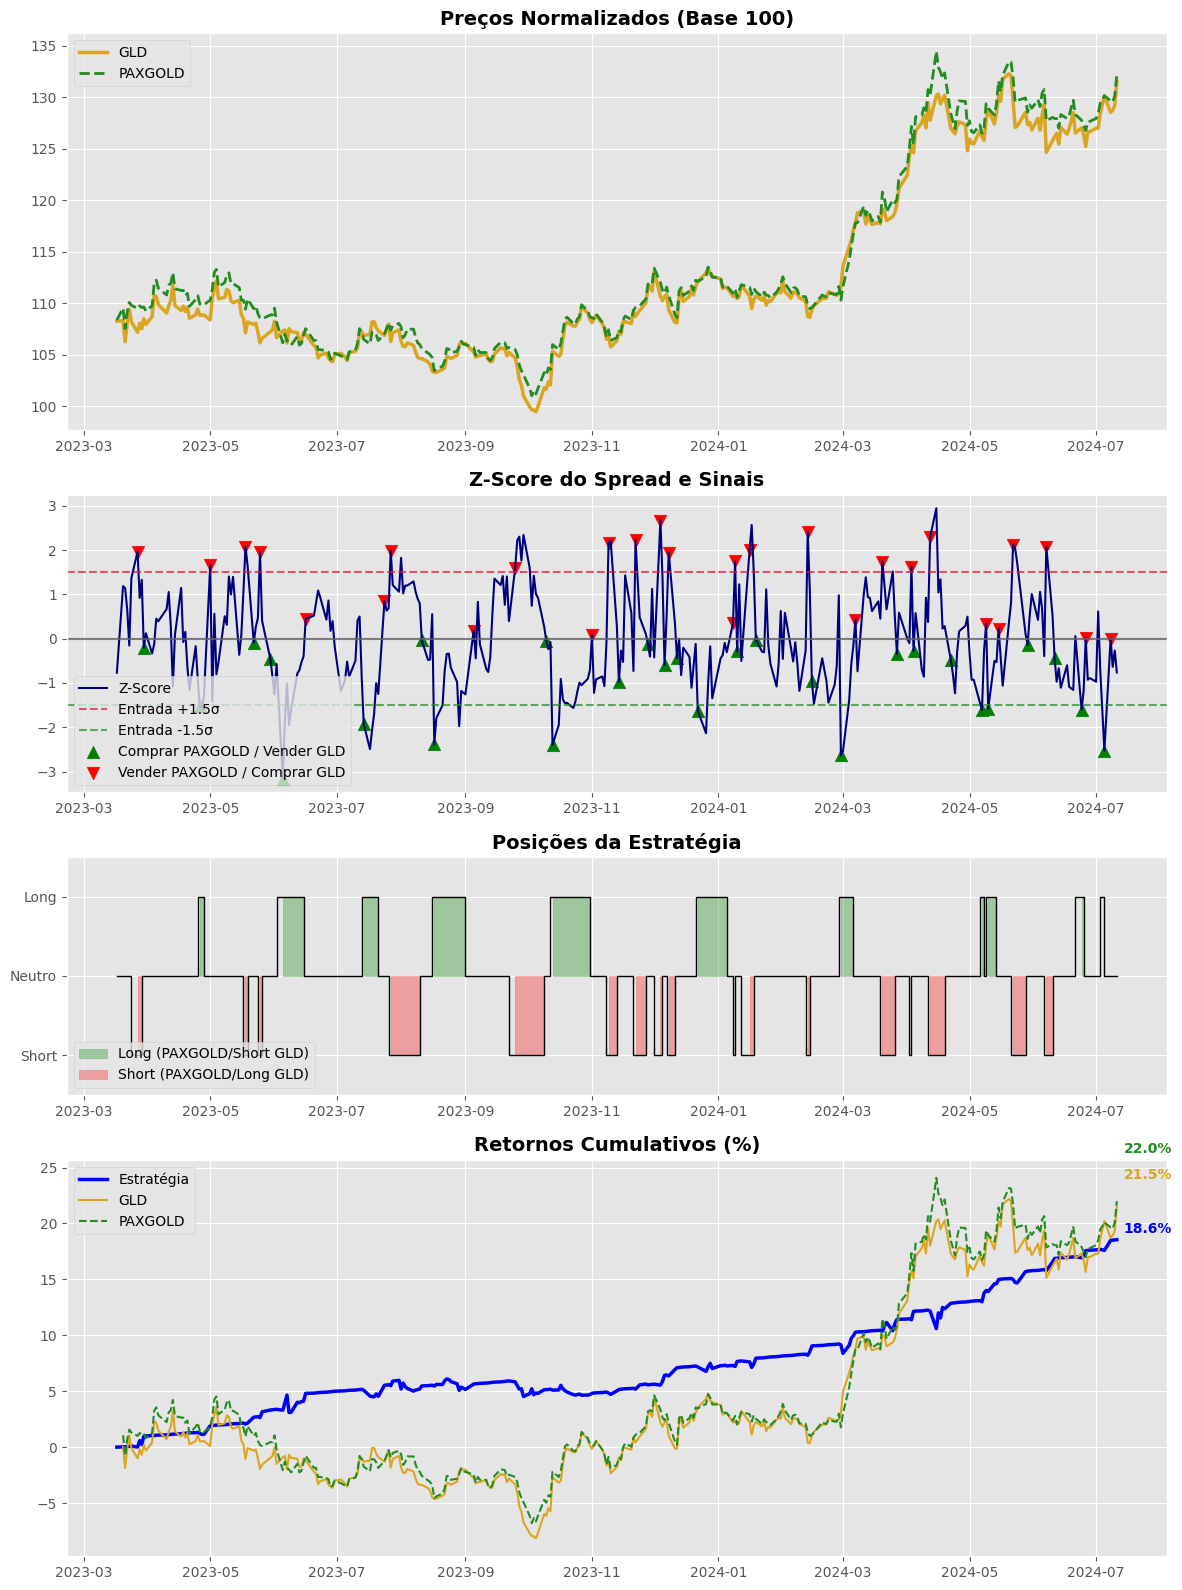

2025-02-26 16:46:36,140 - INFO - Gráfico de capital salvo em: gold_data/capital_curves.png


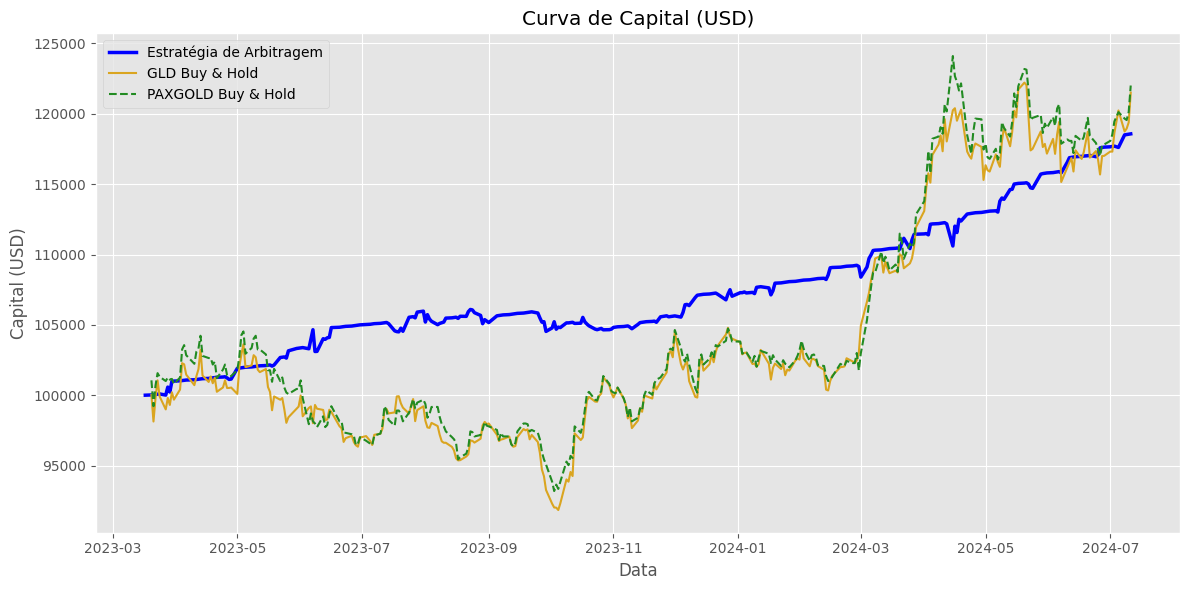

In [21]:
import requests
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import logging
from typing import Optional, Dict, Any, List

# Configurações iniciais
API_KEY: str = 'HO1ZP4R8DC6P1F6W'
FRED_API_KEY: str = 'd9634174ffa703431cec91ede95ac3ee'
DATA_DIR: str = 'gold_data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Parâmetros padrão da estratégia (valores iniciais)
Z_ENTRY: float = 1.5    # Limiar de Z-Score para entrada
Z_EXIT: float = 0.0     # Limiar de Z-Score para saída
USE_EMA: bool = False   # Filtro EMA desativado
Z_WINDOW: int = 14      # Janela para cálculo do Z-Score
FEE: float = 0.001      # Fee de 0,1% por operação

# Configuração de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def load_cache(cache_file: str, max_age_hours: int) -> Optional[pd.DataFrame]:
    """Tenta carregar dados em cache se o arquivo existir e não estiver expirado."""
    if os.path.exists(cache_file):
        file_time = datetime.fromtimestamp(os.path.getmtime(cache_file))
        if datetime.now() - file_time < timedelta(hours=max_age_hours):
            logging.info(f"Usando dados em cache: {cache_file} (modificado em {file_time.strftime('%Y-%m-%d %H:%M:%S')})")
            return pd.read_csv(cache_file, index_col=0, parse_dates=True)
    return None


def save_cache(df: pd.DataFrame, cache_file: str) -> None:
    """Salva o DataFrame em arquivo CSV para cache."""
    df.to_csv(cache_file)
    logging.info(f"Dados salvos em cache: {cache_file}")


class GoldArbitrageStrategy:
    def __init__(self, start_date: Optional[datetime] = None, z_entry: float = Z_ENTRY, 
                 z_exit: float = Z_EXIT, use_ema: bool = USE_EMA, z_window: int = Z_WINDOW) -> None:
        """
        Inicializa a estratégia de arbitragem.
        
        :param start_date: Data inicial para os dados (padrão: dois anos atrás).
        :param z_entry: Limiar de Z-Score para entrada.
        :param z_exit: Limiar de Z-Score para saída.
        :param use_ema: Se True, utiliza filtro baseado na tendência do GLD via EMA.
        :param z_window: Janela para cálculo do z‑score.
        """
        self.start_date: datetime = start_date or (datetime.now() - timedelta(days=365 * 2))
        self.z_entry: float = z_entry
        self.z_exit: float = z_exit
        self.use_ema: bool = use_ema
        self.z_window: int = z_window
        self.gld: Optional[pd.DataFrame] = None
        self.paxg: Optional[pd.DataFrame] = None
        self.df: Optional[pd.DataFrame] = None
        self.metrics: Optional[dict] = None

    def fetch_data(self, symbol: str, use_cached: bool = True, cache_days: int = 7) -> Optional[pd.DataFrame]:
        """
        Busca dados diários de um ativo via Alpha Vantage ou a partir do cache.
        
        :param symbol: Símbolo do ativo (ex.: 'GLD').
        :param use_cached: Se True, tenta usar cache.
        :param cache_days: Dias de validade do cache.
        :return: DataFrame com os dados ou None se ocorrer erro.
        """
        cache_file = f"{DATA_DIR}/{symbol}_TIME_SERIES_DAILY.csv"
        if use_cached:
            df_cache = load_cache(cache_file, max_age_hours=cache_days * 24)
            if df_cache is not None:
                return df_cache

        logging.info(f"Buscando dados de {symbol} via Alpha Vantage...")
        try:
            url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}'
            response = requests.get(url)
            data = response.json()
            for key in ['Error Message', 'Information']:
                if key in data:
                    logging.error(f"{key}: {data[key]}")
                    return None
            time_series_key = next((k for k in data.keys() if 'Time Series' in k), None)
            if not time_series_key or not data.get(time_series_key):
                logging.error("Dados não encontrados para " + symbol)
                return None
            df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
            col_map = {'1. open': 'open', '2. high': 'high', '3. low': 'low',
                       '4. close': 'close', '5. volume': 'volume'}
            df.rename(columns=col_map, inplace=True)
            for col in df.columns:
                df[col] = pd.to_numeric(df[col])
            df.index = pd.to_datetime(df.index)
            df.sort_index(inplace=True)
            save_cache(df, cache_file)
            return df
        except Exception as e:
            logging.error(f"Erro ao buscar dados de {symbol}: {str(e)}")
            return None

    def fetch_paxgold_data_ccxt(self, use_cached: bool = True, cache_hours: int = 12) -> Optional[pd.DataFrame]:
        """
        Busca dados diários do PAXG via CCXT.
        Neste exemplo, utiliza a Binance com o par "PAXG/USDT".
        
        :param use_cached: Se True, tenta usar cache.
        :param cache_hours: Validade do cache em horas.
        :return: DataFrame com os dados ou None se ocorrer erro.
        """
        cache_file = os.path.join(DATA_DIR, "PAXGOLD_CCXT_1d.csv")
        if use_cached:
            df_cache = load_cache(cache_file, max_age_hours=cache_hours)
            if df_cache is not None:
                return df_cache

        try:
            exchange = ccxt.binance({'enableRateLimit': True})
            exchange.load_markets()
            symbol = 'PAXG/USDT'
            timeframe = '1d'
            since = exchange.parse8601((datetime.utcnow() - timedelta(days=365 * 2)).isoformat())
            logging.info(f"Buscando dados de {symbol} na Binance via CCXT...")
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=500)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('datetime', inplace=True)
            df.drop('timestamp', axis=1, inplace=True)
            df.sort_index(inplace=True)
            save_cache(df, cache_file)
            return df
        except Exception as e:
            logging.error(f"Erro ao buscar dados do PAXGOLD via CCXT: {str(e)}")
            return None

    def fetch_risk_free_data(self, series_id: str = 'DTB3', use_cached: bool = True, cache_days: int = 7) -> Optional[pd.DataFrame]:
        """
        Busca dados diários da taxa de juros (risk‑free) do FRED.
        Utiliza a série 'DTB3' (T‑Bill de 3 meses) e converte o rendimento anual para retorno diário.
        
        :param series_id: ID da série no FRED.
        :param use_cached: Se True, utiliza dados em cache.
        :param cache_days: Validade do cache em dias.
        :return: DataFrame com a coluna 'risk_free_return' ou None se ocorrer erro.
        """
        cache_file = os.path.join(DATA_DIR, f"FRED_{series_id}.csv")
        if use_cached:
            df_cache = load_cache(cache_file, max_age_hours=cache_days * 24)
            if df_cache is not None:
                return df_cache

        start_str = self.start_date.strftime('%Y-%m-%d')
        end_str = datetime.now().strftime('%Y-%m-%d')
        url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={FRED_API_KEY}&file_type=json&observation_start={start_str}&observation_end={end_str}"
        logging.info(f"Buscando dados da taxa de juros (FRED: {series_id})...")
        try:
            response = requests.get(url)
            data = response.json()
            if 'observations' not in data:
                logging.error("FRED: 'observations' não encontrado na resposta.")
                return None
            observations = data['observations']
            df = pd.DataFrame(observations)
            df = df[['date', 'value']]
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df = df.dropna().sort_index()
            df['risk_free_return'] = (1 + df['value'] / 100) ** (1 / 252) - 1
            save_cache(df, cache_file)
            return df[['risk_free_return']]
        except Exception as e:
            logging.error(f"Erro ao buscar dados do FRED: {str(e)}")
            return None

    def prepare_data(self) -> bool:
        """
        Prepara os dados para a análise de arbitragem:
         - Busca os dados do GLD via Alpha Vantage e os do PAXG via CCXT.
         - Alinha as datas e filtra a partir de self.start_date.
         - Calcula indicadores técnicos (EMAs), normaliza preços e determina o spread e o z‑score.
         
        :return: True se os dados forem preparados com sucesso, False caso contrário.
        """
        self.gld = self.fetch_data('GLD')
        if self.gld is None:
            logging.error("Não foi possível obter dados para GLD")
            return False

        self.paxg = self.fetch_paxgold_data_ccxt()
        if self.paxg is None:
            logging.error("Não foi possível obter dados para PAXGOLD via CCXT")
            return False

        common_dates = self.gld.index.intersection(self.paxg.index)
        self.gld = self.gld.loc[common_dates]
        self.paxg = self.paxg.loc[common_dates]

        if self.start_date:
            self.gld = self.gld[self.gld.index >= self.start_date]
            self.paxg = self.paxg[self.paxg.index >= self.start_date]

        if len(self.gld) < 50 or len(self.paxg) < 50:
            logging.error("Dados insuficientes após filtro de datas")
            return False

        for df in [self.gld, self.paxg]:
            df['ema_long'] = df['close'].ewm(span=20, adjust=False).mean()
            df['ema_short'] = df['close'].ewm(span=9, adjust=False).mean()

        self.df = pd.DataFrame(index=common_dates)
        self.df = self.df[self.df.index >= self.start_date]
        self.df['gld_price'] = self.gld['close']
        self.df['paxg_price'] = self.paxg['close']

        first_gld = self.gld['close'].iloc[0]
        first_paxg = self.paxg['close'].iloc[0]
        self.df['gld_norm'] = self.gld['close'] / first_gld * 100
        self.df['paxg_norm'] = self.paxg['close'] / first_paxg * 100

        self.df['spread'] = (self.df['paxg_norm'] / self.df['gld_norm'] - 1) * 100
        self.df['spread_mean'] = self.df['spread'].rolling(window=self.z_window).mean()
        self.df['spread_std'] = self.df['spread'].rolling(window=self.z_window).std()
        self.df['z_score'] = (self.df['spread'] - self.df['spread_mean']) / self.df['spread_std']

        self.df['gld_ema_long'] = self.gld['ema_long']
        self.df['gld_ema_short'] = self.gld['ema_short']
        self.df['paxg_ema_long'] = self.paxg['ema_long']
        self.df['paxg_ema_short'] = self.paxg['ema_short']
        self.df['gld_trend'] = np.where(self.df['gld_ema_short'] > self.df['gld_ema_long'], 1, -1)
        self.df['paxg_trend'] = np.where(self.df['paxg_ema_short'] > self.df['paxg_ema_long'], 1, -1)

        self.df.dropna(inplace=True)
        logging.info("Dados preparados com sucesso.")
        return True

    def run_strategy(self) -> bool:
        """
        Executa a estratégia de arbitragem:
         - Gera sinais e posições com base no z‑score (e, se ativado, no filtro EMA).
         - Quando não posicionado (posição 0), utiliza o retorno da taxa risk‑free.
         - Aplica uma fee de 0,1% (0.001) nos dias em que ocorre uma operação.
         - Calcula os retornos diários e cumulativos.
         
        :return: True se a estratégia for executada com sucesso, False caso contrário.
        """
        if self.df is None:
            logging.error("Dados não preparados. Execute prepare_data() primeiro.")
            return False

        self.df['signal'] = 0
        self.df['position'] = 0

        for i in range(1, len(self.df)):
            curr_date = self.df.index[i]
            prev_date = self.df.index[i - 1]
            z_score = self.df.loc[curr_date, 'z_score']
            prev_position = self.df.loc[prev_date, 'position']

            ema_filter = True
            if self.use_ema:
                ema_filter = (self.df.loc[curr_date, 'gld_trend'] == 1)

            if prev_position == 0:
                if z_score <= -self.z_entry and ema_filter:
                    self.df.loc[curr_date, 'signal'] = 1
                    self.df.loc[curr_date, 'position'] = 1
                elif z_score >= self.z_entry and ema_filter:
                    self.df.loc[curr_date, 'signal'] = -1
                    self.df.loc[curr_date, 'position'] = -1
                else:
                    self.df.loc[curr_date, 'position'] = 0
            elif prev_position == 1:
                if z_score >= self.z_exit:
                    self.df.loc[curr_date, 'signal'] = -1
                    self.df.loc[curr_date, 'position'] = 0
                else:
                    self.df.loc[curr_date, 'position'] = 1
            elif prev_position == -1:
                if z_score <= -self.z_exit:
                    self.df.loc[curr_date, 'signal'] = 1
                    self.df.loc[curr_date, 'position'] = 0
                else:
                    self.df.loc[curr_date, 'position'] = -1

        self.df['paxg_return'] = self.df['paxg_price'].pct_change()
        self.df['gld_return'] = self.df['gld_price'].pct_change()

        risk_free_df = self.fetch_risk_free_data()
        if risk_free_df is not None:
            self.df = self.df.merge(risk_free_df, how='left', left_index=True, right_index=True)
            self.df['risk_free_return'] = self.df['risk_free_return'].ffill().fillna(0)
        else:
            self.df['risk_free_return'] = 0

        raw_return = np.where(
            self.df['position'].shift(1).fillna(0) == 0,
            self.df['risk_free_return'],
            self.df['position'].shift(1) * (self.df['paxg_return'] - self.df['gld_return'])
        )
        fee_adjustment = np.where(self.df['signal'] != 0, FEE, 0)
        self.df['arb_return'] = raw_return - fee_adjustment

        self.df['cum_arb'] = (1 + self.df['arb_return']).cumprod() - 1
        self.df['cum_gld'] = (1 + self.df['gld_return']).cumprod() - 1
        self.df['cum_paxg'] = (1 + self.df['paxg_return']).cumprod() - 1

        logging.info("Estratégia executada com sucesso.")
        return True

    def calculate_metrics(self) -> dict:
        """
        Calcula métricas de desempenho da estratégia, como número de trades, retorno total, 
        retorno anualizado, volatilidade, índice Sharpe e drawdown máximo.
        
        :return: Dicionário com as métricas.
        """
        n_days = len(self.df)
        n_trades = int(self.df['signal'].abs().sum())
        win_trades = int(((self.df['arb_return'] > 0) & (self.df['signal'] != 0)).sum())
        win_rate = (win_trades / n_trades * 100) if n_trades > 0 else 0

        total_return = self.df['cum_arb'].iloc[-1] * 100
        gld_return = self.df['cum_gld'].iloc[-1] * 100
        paxg_return = self.df['cum_paxg'].iloc[-1] * 100

        years = n_days / 252
        annual_return = ((1 + total_return/100) ** (1/years) - 1) * 100
        gld_annual = ((1 + gld_return/100) ** (1/years) - 1) * 100
        paxg_annual = ((1 + paxg_return/100) ** (1/years) - 1) * 100

        vol = self.df['arb_return'].std() * np.sqrt(252) * 100
        sharpe = annual_return / vol if vol > 0 else 0

        cumul = (1 + self.df['arb_return']).cumprod()
        peak = np.maximum.accumulate(cumul)
        drawdown = (cumul / peak - 1) * 100
        max_dd = drawdown.min()

        self.metrics = {
            'days': n_days,
            'trades': n_trades,
            'win_rate': win_rate,
            'total_return': total_return,
            'annual_return': annual_return,
            'gld_return': gld_return,
            'paxg_return': paxg_return,
            'gld_annual': gld_annual,
            'paxg_annual': paxg_annual,
            'volatility': vol,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'years': years
        }
        return self.metrics

    def generate_report(self) -> None:
        """
        Gera e imprime um relatório resumido da estratégia.
        """
        if not hasattr(self, 'metrics'):
            self.calculate_metrics()
        m = self.metrics
        
        report = (
            "\n=== ARBITRAGEM OURO (GLD vs PAXGOLD) ===\n"
            f"Período: {self.df.index[0].strftime('%d/%m/%Y')} a {self.df.index[-1].strftime('%d/%m/%Y')} ({m['days']} dias)\n\n"
            "PARÂMETROS OTIMIZADOS:\n"
            f"  Z-Score Entrada: {self.z_entry}\n"
            f"  Z-Score Saída: {self.z_exit}\n"
            f"  Uso de filtro EMA: {self.use_ema}\n\n"
            "RESULTADOS:\n"
            f"{'Estratégia:':25} {m['total_return']:7.2f}% ({m['annual_return']:6.2f}% anual)\n"
            f"{'GLD Buy & Hold:':25} {m['gld_return']:7.2f}% ({m['gld_annual']:6.2f}% anual)\n"
            f"{'PAXGOLD Buy & Hold:':25} {m['paxg_return']:7.2f}% ({m['paxg_annual']:6.2f}% anual)\n\n"
            "MÉTRICAS DE RISCO:\n"
            f"{'Volatilidade Anualizada:':25} {m['volatility']:7.2f}%\n"
            f"{'Índice Sharpe:':25} {m['sharpe']:7.2f}\n"
            f"{'Drawdown Máximo:':25} {m['max_drawdown']:7.2f}%\n\n"
            "OPERAÇÕES:\n"
            f"{'Número de Trades:':25} {m['trades']}\n"
            f"{'Taxa de Acerto:':25} {m['win_rate']:7.2f}%\n"
            f"{'Trades por Ano:':25} {m['trades']/m['years']:7.2f}\n"
        )
        print(report)

    def plot_results(self) -> None:
        """
        Gera gráficos dos resultados (preços normalizados, z‑score, posições, retornos cumulativos em % e curva de capital em USD).
        """
        plt.style.use('ggplot')
        fig, axes = plt.subplots(4, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [2, 1.5, 1.2, 2]})
        
        # 1. Preços normalizados
        axes[0].plot(self.df.index, self.df['gld_norm'], label='GLD', color='#DAA520', linewidth=2.5)
        axes[0].plot(self.df.index, self.df['paxg_norm'], label='PAXGOLD', color='#228B22', linewidth=2, linestyle='--')
        axes[0].set_title('Preços Normalizados (Base 100)', fontsize=14, fontweight='bold')
        axes[0].legend(loc='best')
        
        # 2. Z-Score e sinais
        axes[1].plot(self.df.index, self.df['z_score'], label='Z-Score', color='navy', linewidth=1.5)
        axes[1].axhline(y=self.z_entry, color='crimson', linestyle='--', alpha=0.7, label=f'Entrada +{self.z_entry}σ')
        axes[1].axhline(y=-self.z_entry, color='forestgreen', linestyle='--', alpha=0.7, label=f'Entrada -{self.z_entry}σ')
        axes[1].axhline(y=self.z_exit, color='gray', linestyle='-', alpha=0.5)
        axes[1].axhline(y=-self.z_exit, color='gray', linestyle='-', alpha=0.5)
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.2)
        buy_signals = self.df[self.df['signal'] == 1].index
        sell_signals = self.df[self.df['signal'] == -1].index
        if not buy_signals.empty:
            axes[1].scatter(buy_signals, self.df.loc[buy_signals, 'z_score'], marker='^', color='green', s=80,
                            label='Comprar PAXGOLD / Vender GLD')
        if not sell_signals.empty:
            axes[1].scatter(sell_signals, self.df.loc[sell_signals, 'z_score'], marker='v', color='red', s=80,
                            label='Vender PAXGOLD / Comprar GLD')
        axes[1].set_title('Z-Score do Spread e Sinais', fontsize=14, fontweight='bold')
        axes[1].legend(loc='best')
        
        # 3. Posições
        axes[2].step(self.df.index, self.df['position'], color='black', linewidth=1)
        axes[2].fill_between(self.df.index, self.df['position'], 0,
                             where=self.df['position'] > 0, color='green', alpha=0.3, label='Long (PAXGOLD/Short GLD)')
        axes[2].fill_between(self.df.index, self.df['position'], 0,
                             where=self.df['position'] < 0, color='red', alpha=0.3, label='Short (PAXGOLD/Long GLD)')
        axes[2].set_title('Posições da Estratégia', fontsize=14, fontweight='bold')
        axes[2].set_ylim(-1.5, 1.5)
        axes[2].set_yticks([-1, 0, 1])
        axes[2].set_yticklabels(['Short', 'Neutro', 'Long'])
        axes[2].legend(loc='best')
        
        # 4. Retornos cumulativos (%)
        axes[3].plot(self.df.index, self.df['cum_arb'] * 100, label='Estratégia', color='blue', linewidth=2.5)
        axes[3].plot(self.df.index, self.df['cum_gld'] * 100, label='GLD', color='#DAA520', linewidth=1.5)
        axes[3].plot(self.df.index, self.df['cum_paxg'] * 100, label='PAXGOLD', color='#228B22', linewidth=1.5, linestyle='--')
        axes[3].set_title('Retornos Cumulativos (%)', fontsize=14, fontweight='bold')
        axes[3].legend(loc='best')
        for i, (label, col, color) in enumerate([
            ('Arb', 'cum_arb', 'blue'),
            ('GLD', 'cum_gld', '#DAA520'),
            ('PAXG', 'cum_paxg', '#228B22')
        ]):
            ret = self.df[col].iloc[-1] * 100
            axes[3].annotate(f'{ret:.1f}%', 
                             xy=(self.df.index[-1], self.df[col].iloc[-1]*100),
                             xytext=(5, 5+i*15), textcoords='offset points',
                             color=color, fontweight='bold')
        
        plt.tight_layout()
        percent_report_path = f"{DATA_DIR}/gold_paxg_arbitrage_report.png"
        plt.savefig(percent_report_path, dpi=300, bbox_inches='tight')
        logging.info(f"Gráfico percentual salvo em: {percent_report_path}")
        plt.show()
        
        # Gráfico adicional: Curva de Capital (em USD)
        INITIAL_CAPITAL = 100000
        capital_arb = INITIAL_CAPITAL * (1 + self.df['cum_arb'])
        capital_gld = INITIAL_CAPITAL * (1 + self.df['cum_gld'])
        capital_paxg = INITIAL_CAPITAL * (1 + self.df['cum_paxg'])
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, capital_arb, label='Estratégia de Arbitragem', color='blue', linewidth=2.5)
        plt.plot(self.df.index, capital_gld, label='GLD Buy & Hold', color='#DAA520', linewidth=1.5)
        plt.plot(self.df.index, capital_paxg, label='PAXGOLD Buy & Hold', color='#228B22', linewidth=1.5, linestyle='--')
        plt.title('Curva de Capital (USD)')
        plt.xlabel('Data')
        plt.ylabel('Capital (USD)')
        plt.legend(loc='best')
        plt.tight_layout()
        capital_report_path = f"{DATA_DIR}/capital_curves.png"
        plt.savefig(capital_report_path, dpi=300, bbox_inches='tight')
        logging.info(f"Gráfico de capital salvo em: {capital_report_path}")
        plt.show()

    def run_full_analysis(self) -> bool:
        """
        Executa toda a análise: prepara os dados, roda a estratégia, calcula métricas,
        gera relatório e plota os resultados.
        
        :return: True se a análise for bem-sucedida, False caso contrário.
        """
        logging.info("Iniciando análise completa da estratégia de arbitragem (GLD vs PAXGOLD)...")
        if not self.prepare_data():
            logging.error("Falha na preparação dos dados.")
            return False

        if not self.run_strategy():
            logging.error("Falha na execução da estratégia.")
            return False

        self.calculate_metrics()
        self.generate_report()
        self.plot_results()
        return True


def optimize_parameters(start_date: datetime) -> Dict[str, Any]:
    """
    Realiza uma pesquisa em grade para testar diferentes combinações de parâmetros e retorna a melhor configuração
    com base no retorno absoluto (total_return).

    :param start_date: Data inicial para os dados.
    :return: Dicionário com os melhores parâmetros e métricas associadas.
    """
    # Faixas de parâmetros para testar
    z_entry_values = [1.5, 2.0, 2.5]
    z_exit_values = [0.0, 0.5]
    use_ema_values = [False, True]
    z_window_values = [14, 21, 30]

    results: List[Dict[str, Any]] = []

    for z_entry in z_entry_values:
        for z_exit in z_exit_values:
            for use_ema in use_ema_values:
                for z_window in z_window_values:
                    logging.info(f"Testando parâmetros: z_entry={z_entry}, z_exit={z_exit}, use_ema={use_ema}, z_window={z_window}")
                    strat = GoldArbitrageStrategy(start_date=start_date, z_entry=z_entry, z_exit=z_exit,
                                                   use_ema=use_ema, z_window=z_window)
                    if not strat.prepare_data():
                        continue
                    if not strat.run_strategy():
                        continue
                    metrics = strat.calculate_metrics()
                    results.append({
                        'z_entry': z_entry,
                        'z_exit': z_exit,
                        'use_ema': use_ema,
                        'z_window': z_window,
                        'total_return': metrics['total_return'],
                        'annual_return': metrics['annual_return'],
                        'sharpe': metrics['sharpe'],
                        'win_rate': metrics['win_rate'],
                        'trades': metrics['trades']
                    })
                    logging.info(f"-> Total Return: {metrics['total_return']:.2f}%, Sharpe: {metrics['sharpe']:.2f}, Win Rate: {metrics['win_rate']:.2f}%")

    if results:
        best = max(results, key=lambda r: r['total_return'])
        logging.info(f"Melhor configuração encontrada (por retorno absoluto): {best}")
        return best
    else:
        logging.error("Nenhuma configuração válida foi encontrada.")
        return {}


if __name__ == "__main__":
    # Define a data de início para os testes (ex.: 01/01/2022)
    start_date = datetime(2022, 1, 1)
    
    # Otimiza os parâmetros com base no retorno absoluto
    best_params = optimize_parameters(start_date)
    print("\n=== Melhor Configuração Encontrada ===")
    print(best_params)
    
    # Executa a estratégia com os melhores parâmetros encontrados e plota os resultados finais
    strategy = GoldArbitrageStrategy(start_date=start_date,
                                     z_entry=best_params.get('z_entry', Z_ENTRY),
                                     z_exit=best_params.get('z_exit', Z_EXIT),
                                     use_ema=best_params.get('use_ema', USE_EMA),
                                     z_window=best_params.get('z_window', Z_WINDOW))
    strategy.run_full_analysis()
